# Identifying Negative Sentiment in Tweets

## Business Problem

Google is seeking to increase Android's share of the U.S. smartphone and tablet markets.  To do so, they are seeking information on what consumers don't like about their devices.  By focusing on pain points, they hope to engineer improvements that will attract and retain more customers.

While negative sentiment toward products is available in form of survey responses and customer complaints, Google also hopes to access the opinions conveyed in social media posts.  To do so, they need to identify posts which express concerns and frustrations about mobile devices from among thousands of other posts.

My task is to build a model which can quickly analyze a group of posts and pinpoint those with negative sentiment.

## Data Understanding

To identify posts with gripes, I analyzed over 9,000 tweets from a dataset provided by Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions).  The tweets all contain references to Google or Apple products, and relate to the SXSW (South by Southwest) Conference in 2011.  Although the data are a decade old, and the products discussed seem ancient (iPad 2?), the words used to convey negative emotions have not changed.  

Each tweet in the dataset has been rated by humans as showing a positive emotion, negative emotion, or no emotion toward the Google or Apple product mentioned.  59% of tweets were tagged as postive and 6% as negative, making negative tweets the smallest category by far.  I combined the positive and no-emotion categories in order to build a binary classification model that can weed out all but the negative tweets.

In [1]:
# import libraries

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from gensim.models import Word2Vec

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# import data

data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')

In [3]:
data.head(100)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion


In [4]:
# shorten column names

data.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product': 'label'}, inplace=True)

In [5]:
# drop this column since this model will only predict sentiment, not the product as well

data.drop(columns = 'emotion_in_tweet_is_directed_at', inplace=True)

In [6]:
# check out label distribution

data['label'].value_counts(normalize=True)

No emotion toward brand or product   0.59265
Positive emotion                     0.32750
Negative emotion                     0.06269
I can't tell                         0.01716
Name: label, dtype: float64

In [7]:
# combine "No emotion toward brand or product" and "I can't tell"
# shorten combined label name to "No emotion"

data['label'] = data['label'].map(lambda x: 'Not negative' if x != "Negative emotion"
                                 else x)

In [8]:
# check out new label distribution

data['label'].value_counts(normalize=True)

Not negative       0.93731
Negative emotion   0.06269
Name: label, dtype: float64

In [9]:
# create stopwords list

stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
stopwords_list += ['sxsw','mention','rt']

In [10]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
# create X and y

X = data['text']
y = data['label']

In [12]:
# reformat X to lowercase and string (some tweets were numeric)

X = X.astype(str).map(lambda x: x.lower())

In [13]:
# create holdout set

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.05)

print(len(X_train), len(X_holdout))

8638 455


In [14]:
# create count vectorizer for testing

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)

In [15]:
# create Multinomial Naive Bayes model for testing

nb_count = MultinomialNB()
nb_count.fit(X_train_cv, y_train)
y_train_count_nb_pred = nb_count.predict(X_train_cv)

In [16]:
print(cross_val_score(nb_count, X_train_cv, y=y_train, cv=5).mean())

0.9223194658903259


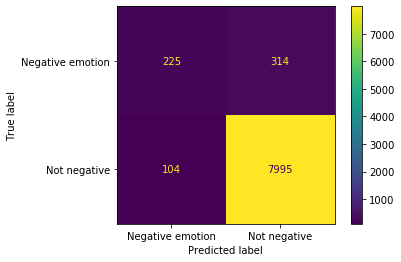

In [17]:
plot_confusion_matrix(nb_count, X_train_cv, y_train)

In [18]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

In [19]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_train_tfidf_pred = nb_tfidf.predict(X_train_tfidf)

In [20]:
print(cross_val_score(nb_tfidf, X_train_tfidf, y=y_train, cv=5).mean())

0.9377170055115915


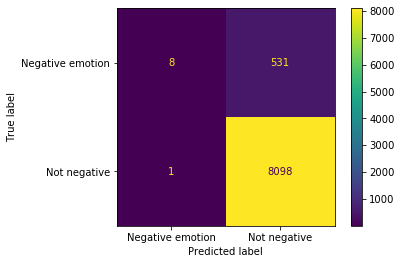

In [21]:
plot_confusion_matrix(nb_tfidf, X_train_tfidf, y_train)

In [22]:
cv_stop = CountVectorizer(stop_words=stopwords_list)
X_train_cv_stop = cv_stop.fit_transform(X_train)

In [23]:
nb_cv_stop = MultinomialNB()
nb_cv_stop.fit(X_train_cv_stop, y_train)
y_train_cv_stop_pred = nb_cv_stop.predict(X_train_cv_stop)

In [24]:
print(cross_val_score(nb_cv_stop, X_train_cv_stop, y=y_train, cv=5).mean())

0.9135217622080679


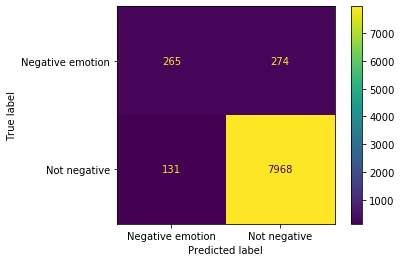

In [25]:
plot_confusion_matrix(nb_cv_stop, X_train_cv_stop, y_train)

In [26]:
tfidf_stop = TfidfVectorizer(stop_words=stopwords_list)
X_train_tfidf_stop = tfidf_stop.fit_transform(X_train)

In [27]:
nb_tfidf_stop = MultinomialNB()
nb_tfidf_stop.fit(X_train_tfidf_stop, y_train)
y_train_tfidf_stop_pred = nb_tfidf_stop.predict(X_train_tfidf_stop)

In [28]:
print(cross_val_score(nb_tfidf_stop, X_train_tfidf_stop, y=y_train, cv=5).mean())

0.9379486210298312


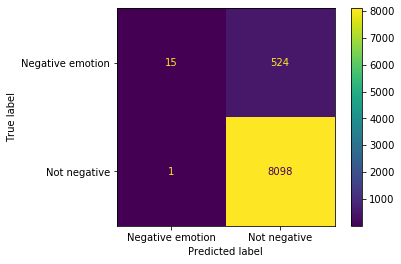

In [29]:
plot_confusion_matrix(nb_tfidf_stop, X_train_tfidf_stop, y_train)

In [41]:
# use glove

X_train_tokens = X_train.map(lambda x: word_tokenize(x))

In [31]:
total_vocabulary = set(word for tweet in X_train_tokens for word in tweet)

In [32]:
len(total_vocabulary)

10579

In [33]:
# from Codealong

glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [34]:
glove['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [35]:
# from Codealong

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self

    # added this method to work more easily with NLP_model_tester function
    def fit_transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])
    
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [36]:
vec_list = [
           ('CountVectorizer', CountVectorizer()),
           ('TfidfVectorizer', TfidfVectorizer()),
           ('W2vVectorizer', W2vVectorizer(glove))]
mod_list = [
           # ('Multinomial Naive Bayes', MultinomialNB()),
           ('Random Forest', RandomForestClassifier()),
           ('Support Vector Machine', SVC()),
           ('Logistic Regression', LogisticRegression())]

In [37]:
def NLP_model_tester(X, y, vectorizers, models, cv=5):
    
    X_tra, X_tst, y_tra, y_tst = train_test_split(X, y, test_size=0.3)
    
    for v in vectorizers:
        for m in models:
            
            X_vec_tra = v[1].fit_transform(X_tra)
            X_vec_tst = v[1].transform(X_tst)
            
            model = m[1]
            model.fit(X_vec_tra, y_tra)
            
            y_pred_tra = m[1].predict(X_vec_tra)
            y_pred_tst = m[1].predict(X_vec_tst)
            
            print(v[0], '/', m[0], 'Train Recall:', round(recall_score(y_tra, y_pred_tra, pos_label='Negative emotion'), 2))
            print(v[0], '/', m[0], 'Train Precision:', round(precision_score(y_tra, y_pred_tra, pos_label='Negative emotion'), 2))

            plot_confusion_matrix(model, X_vec_tra, y_tra)
            plt.title(v[0] + '/' + m[0] + ' Train set')

            print(v[0], '/', m[0], 'Test Recall:', round(recall_score(y_tst, y_pred_tst, pos_label='Negative emotion'), 2))
            print(v[0], '/', m[0], 'Test Precision:', round(precision_score(y_tst, y_pred_tst, pos_label='Negative emotion'), 2))

            plot_confusion_matrix(model, X_vec_tst, y_tst)
            plt.title(v[0] + '/' + m[0] + ' Test set')

            

CountVectorizer / Random Forest Train Recall: 1.0
CountVectorizer / Random Forest Train Precision: 1.0
CountVectorizer / Random Forest Test Recall: 0.18
CountVectorizer / Random Forest Test Precision: 0.7
CountVectorizer / Support Vector Machine Train Recall: 0.23
CountVectorizer / Support Vector Machine Train Precision: 0.99
CountVectorizer / Support Vector Machine Test Recall: 0.07
CountVectorizer / Support Vector Machine Test Precision: 1.0
CountVectorizer / Logistic Regression Train Recall: 0.63
CountVectorizer / Logistic Regression Train Precision: 0.99
CountVectorizer / Logistic Regression Test Recall: 0.22
CountVectorizer / Logistic Regression Test Precision: 0.57
TfidfVectorizer / Random Forest Train Recall: 0.99
TfidfVectorizer / Random Forest Train Precision: 1.0
TfidfVectorizer / Random Forest Test Recall: 0.17
TfidfVectorizer / Random Forest Test Precision: 0.69
TfidfVectorizer / Support Vector Machine Train Recall: 0.37
TfidfVectorizer / Support Vector Machine Train Precis

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


W2vVectorizer / Support Vector Machine Test Recall: 0.0
W2vVectorizer / Support Vector Machine Test Precision: 0.0


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defin

W2vVectorizer / Logistic Regression Train Recall: 0.0
W2vVectorizer / Logistic Regression Train Precision: 0.0
W2vVectorizer / Logistic Regression Test Recall: 0.0
W2vVectorizer / Logistic Regression Test Precision: 0.0


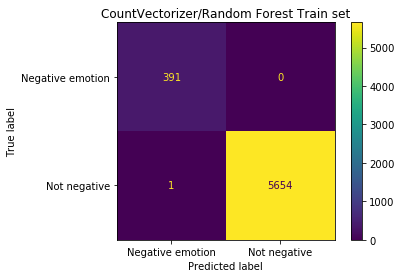

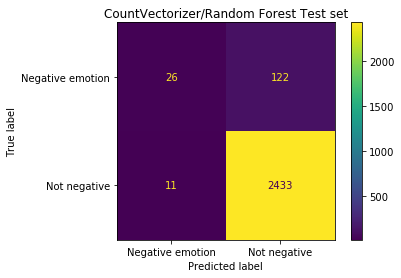

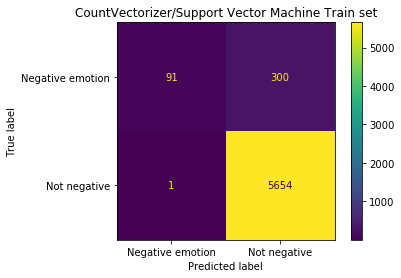

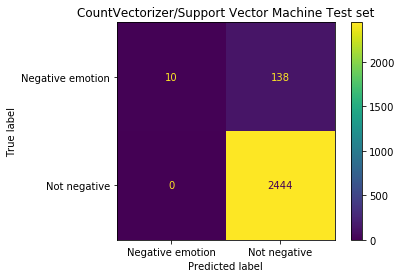

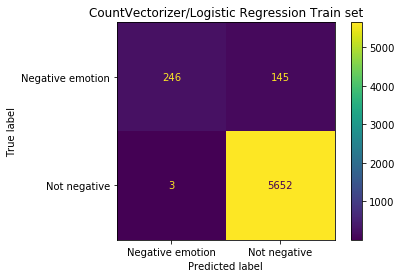

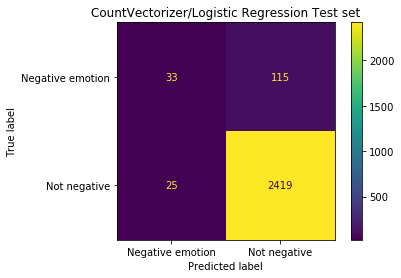

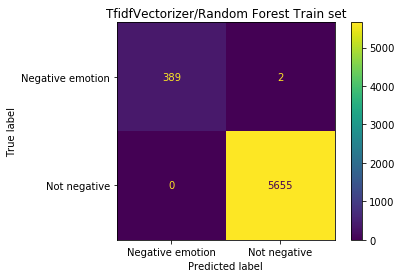

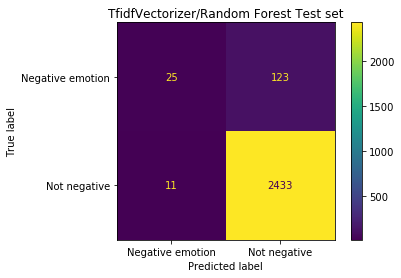

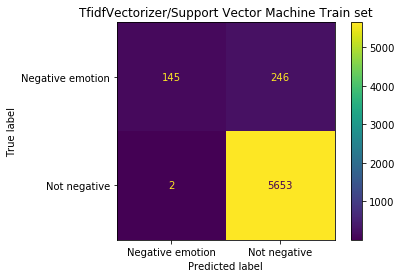

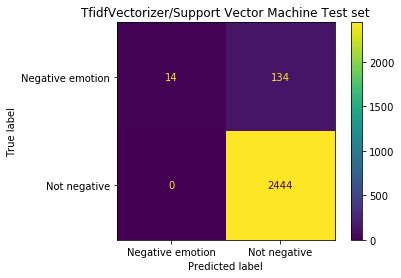

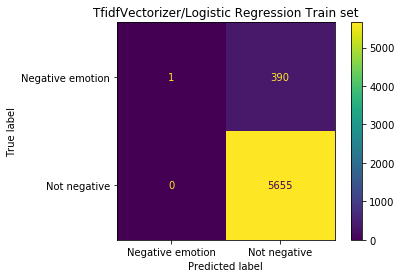

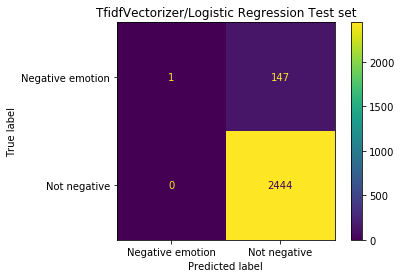

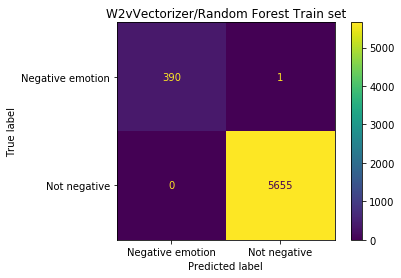

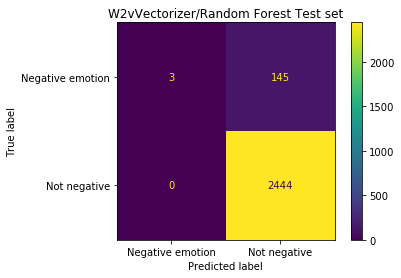

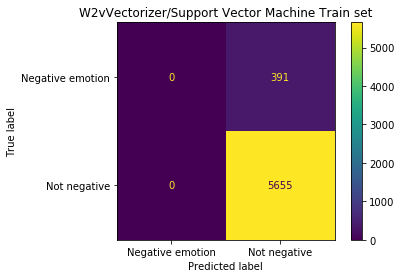

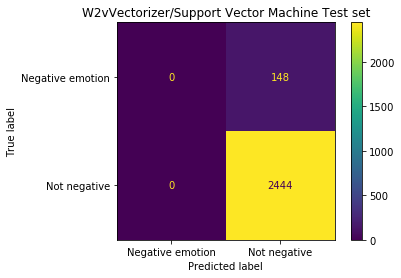

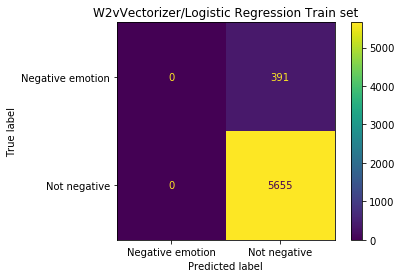

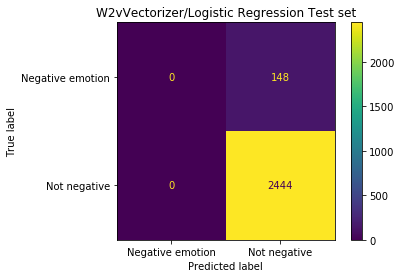

In [38]:
NLP_model_tester(X_train, y_train, vec_list, mod_list, cv=2)

In [39]:
def k_fold_validator(X, y, vectorizer, model, cv=5):

    kf = KFold(n_splits=cv)

    train_recall_scores = []
    train_precision_scores = []
    test_recall_scores = []
    test_precision_scores = []

    for train_index, test_index in kf.split(X):

        X_tr, X_test = X[train_index], X[test_index]
        y_tr, y_test = y[train_index], y[test_index]

        X_vec_train = vectorizer.fit_transform(X_tr)
        X_vec_test = vectorizer.transform(X_test)

        model.fit(X_vec_train, y_tr)

        y_pred_train = model.predict(X_vec_train)
        y_pred_test = model.predict(X_vec_test)

        train_recall_scores.append(recall_score(y_tr, y_pred_train, pos_label='Negative emotion'))
        train_precision_scores.append(precision_score(y_tr, y_pred_train, pos_label='Negative emotion'))
        test_recall_scores.append(recall_score(y_test, y_pred_test, pos_label='Negative emotion'))
        test_precision_scores.append(precision_score(y_test, y_pred_test, pos_label='Negative emotion'))

        plot_confusion_matrix(model, X_vec_train, y_tr)
        plt.title('Train set')
        
        plot_confusion_matrix(model, X_vec_test, y_test)
        plt.title('Test set')
        
    print('Vectorizer:', vectorizer)
    print('Classifier:', model)
    print('Cross-validation folds:', cv)
    print('Train mean recall:', pd.Series(train_recall_scores).mean())
    print('Train mean precision:', pd.Series(train_precision_scores).mean())
    print('Test mean recall:', pd.Series(test_recall_scores).mean())
    print('Test mean precision:', pd.Series(test_precision_scores).mean())



In [43]:
type(X_train[0])

str

In [40]:
k_fold_validator(X_train, y_train, CountVectorizer(), RandomForestClassifier(), cv=5)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
k_fold_validator(X_train, y_train, CountVectorizer(), SVC(), cv=5)

In [ ]:
k_fold_validator(X_train, y_train, CountVectorizer(), LogisticRegression(), cv=5)

In [ ]:
# try a neural net

one_hot_y = pd.get_dummies(y_train).values

In [ ]:
one_hot_y

In [ ]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
list_tokenized_tweets = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=100)

In [ ]:
nn = Sequential()
embedding_size = 128
nn.add(Embedding(5000, embedding_size))
nn.add(LSTM(25, return_sequences=True))
nn.add(GlobalMaxPool1D())
nn.add(Dropout(0.5))
nn.add(Dense(50, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(2, activation='softmax'))

nn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


nn.summary()

In [ ]:
nn.fit(X_t, one_hot_y, epochs=10, validation_split=0.1)

In [ ]:
# make a df
# pd.DataFrame(columns =)

nn.predict(X_t)